MLS-MPM (Moving Least Squares Material point method)

TODO:
1. read mpm_lagrangian_forces.py
2. read through momentum conservation proofs in paper
3. line 105 in mpm1.py

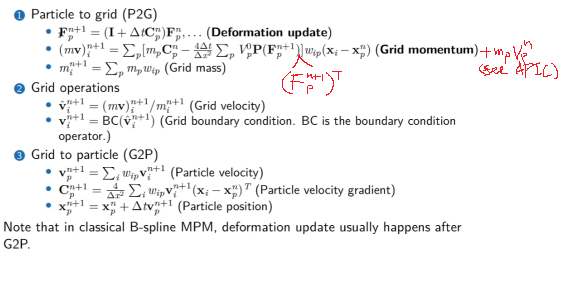

P2G and G2P are designed to conserve momentum, angular momentum and affine velocity field $v+C x_p$ for matrix $C$.


An angular momentum conserving affine-particle-in-cell method, Chenfanfu Jiang et al.

Convention: $i,j$ loop over grid, $p$ loops over particle

#### 1st equation

From MPM Course:
The deformation gradient of the deformation map $\phi$ is
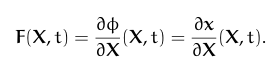

Lagrangian velocity and acceleration are
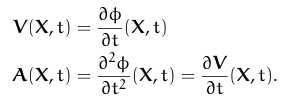

substitute to Eulerian frame it becomes
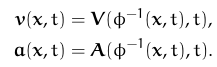

so we do material derivative in the Euler frame
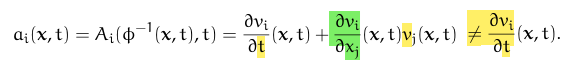

The time derivative of deformation gradient is
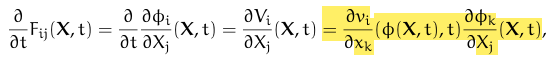
i.e.
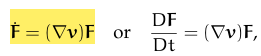

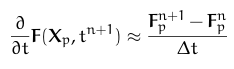
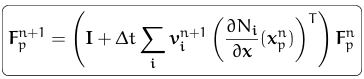

where $N$ is the quadratic/cubic B-splie interpolation, 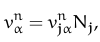, 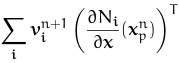, approximated by $C_p^n$ in MLS-MPM, is $\nabla v$ at $x_p^n$

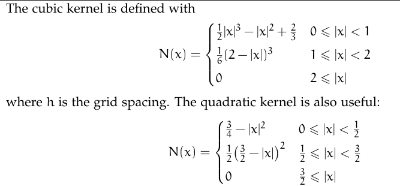

In normal MPM,
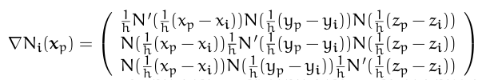
need to be evaluated as shown above. However, MLS-MPM simplified this with magical math.

#### 2nd equation

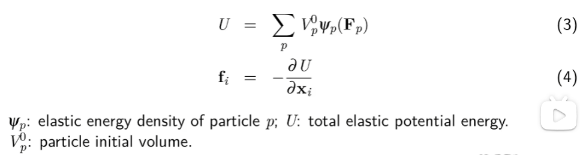
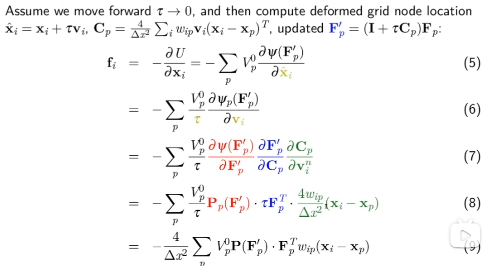

(step 8 prove $\frac{\partial F'_p}{\partial C_p}\frac{C_p}{\partial v_i^n} = \tau F_p^T\cdot\frac{4 w_{ip}}{\Delta x^2}(x_i-x_p)$ using index notation)

Boundary conditions

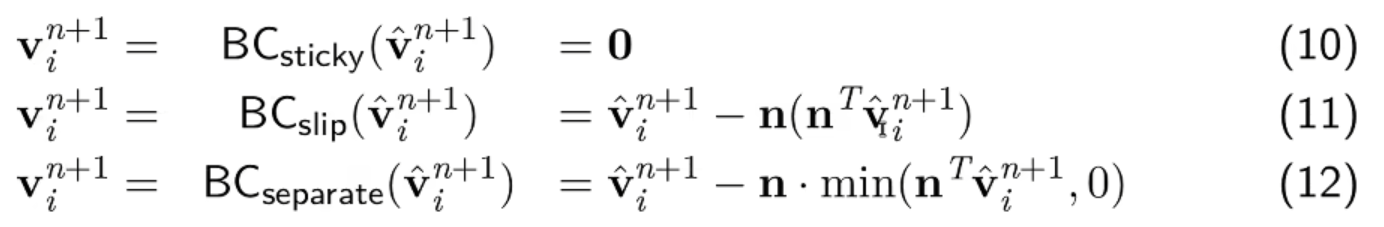

(11) is bad, speed away from the wall also subtracted!

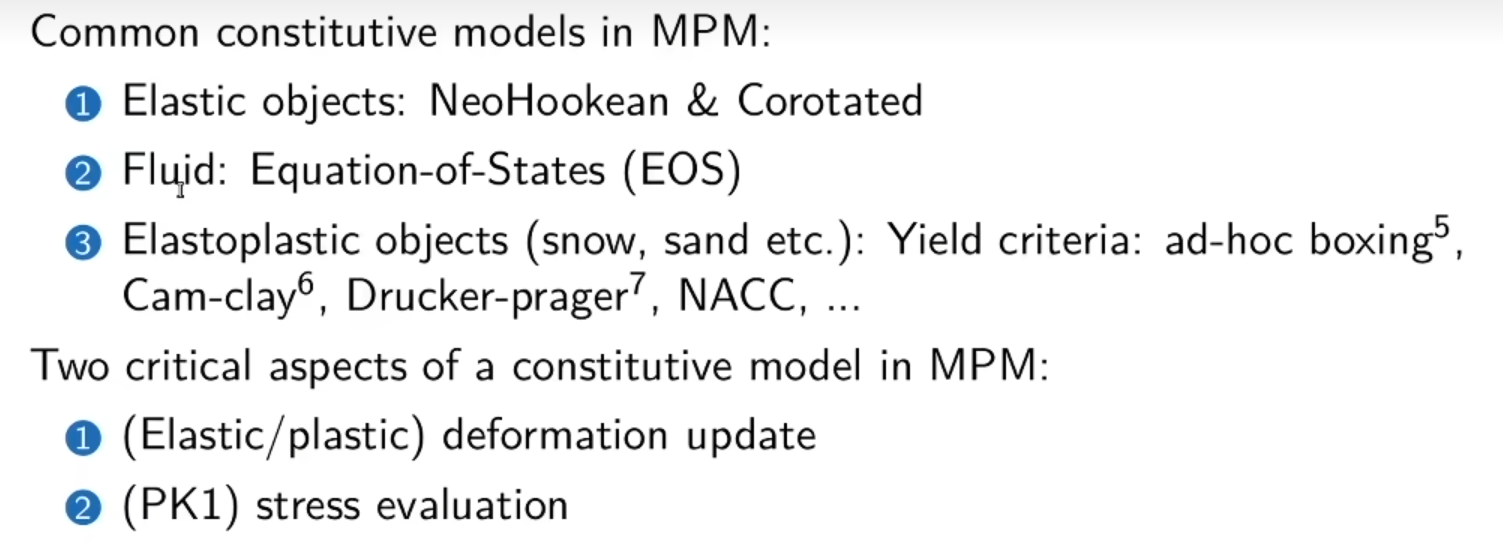

Yield criteria: when it breaks. We'll use ad-hoc for simplicity (non-physical warning)

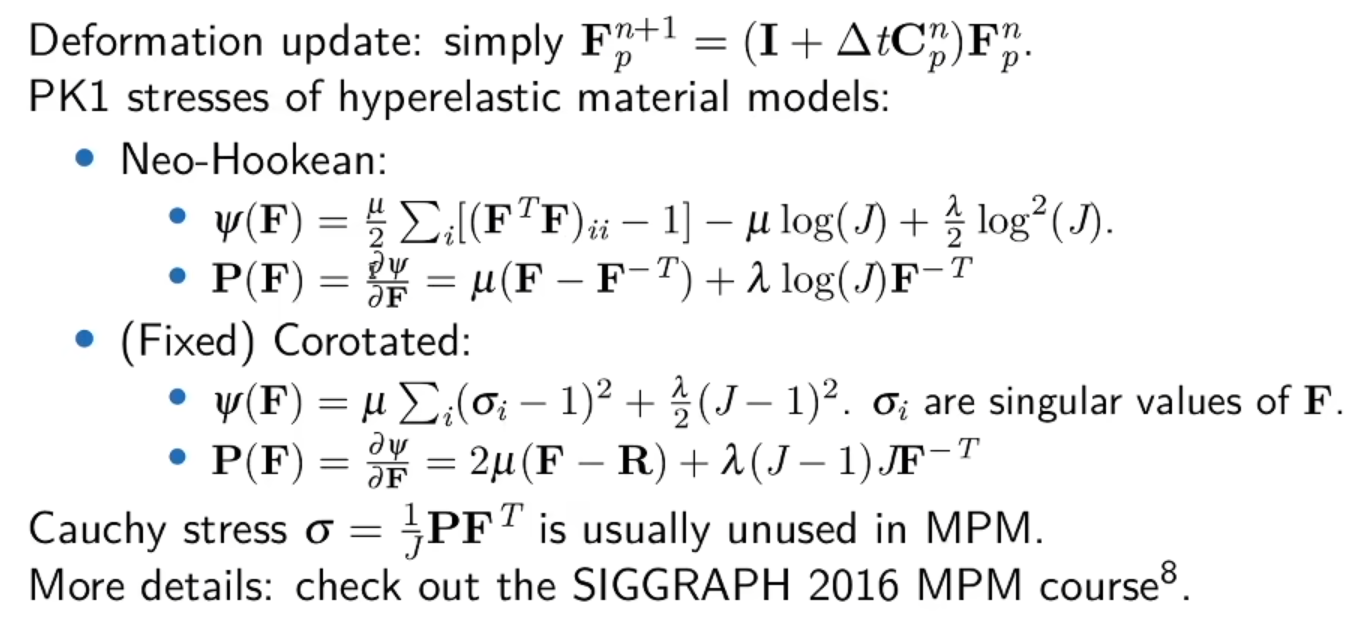

where $F=RS$ is the polar decomposition, where $S=(F^TF)^{1/2}=(V\Sigma U^T U\Sigma V^T)^{1/2}=(V\Sigma^2 V^T)^{1/2}=V\Sigma V^T$, $R=UV^T$

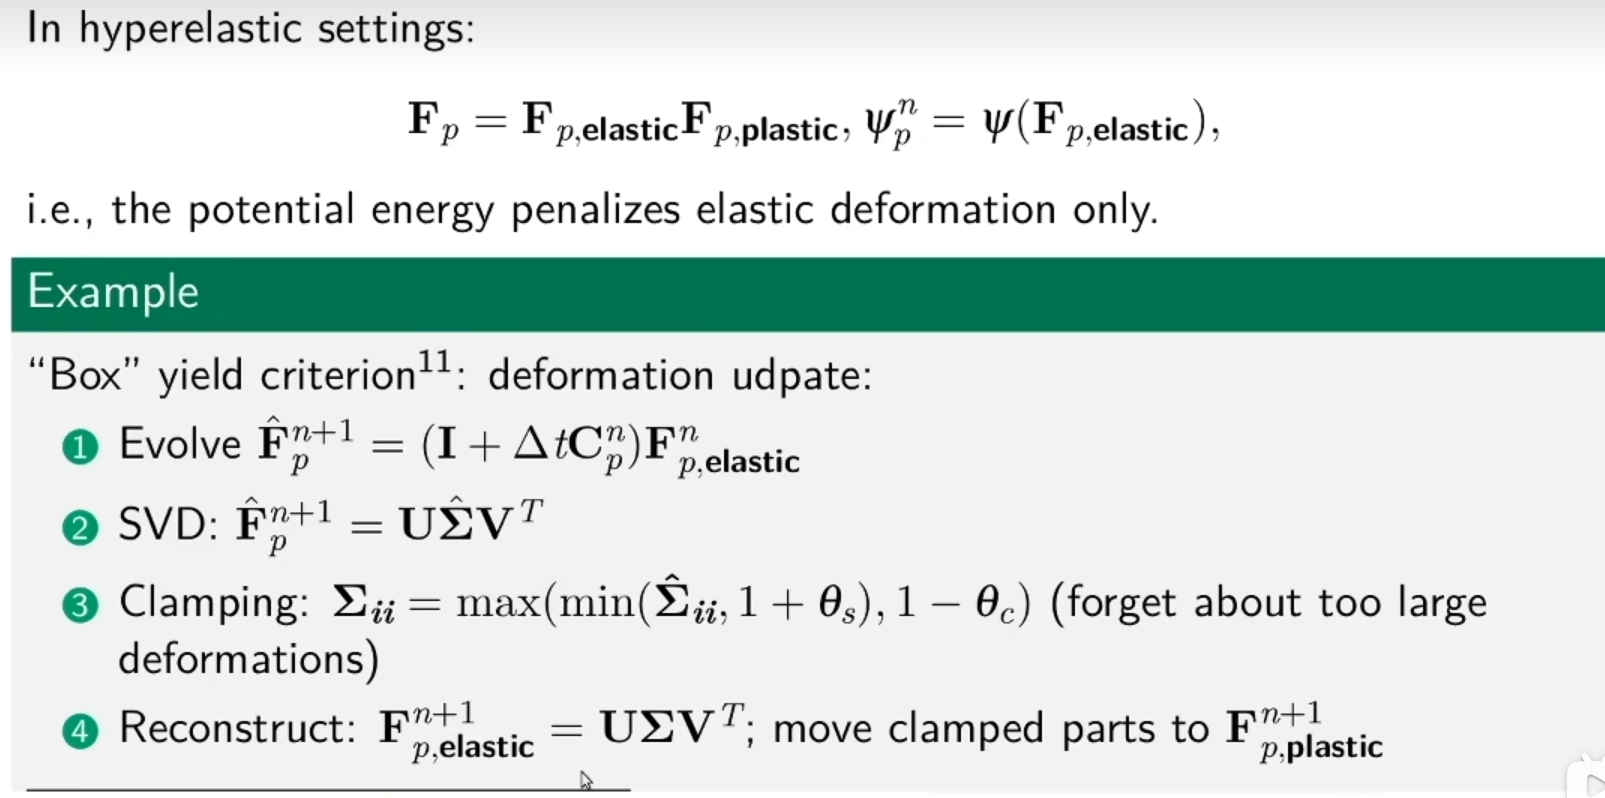

$\theta_s$ and $\theta_c$ affect the upper and lower limit of elastic deformation (otherwise plastic) (no reason, ad-hoc, use cam-clay to improve, yes cam stands for cambridge)

hardening effect of snow ($\mu,\lambda$ change when stretched or compressed)

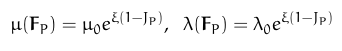

#### APIC
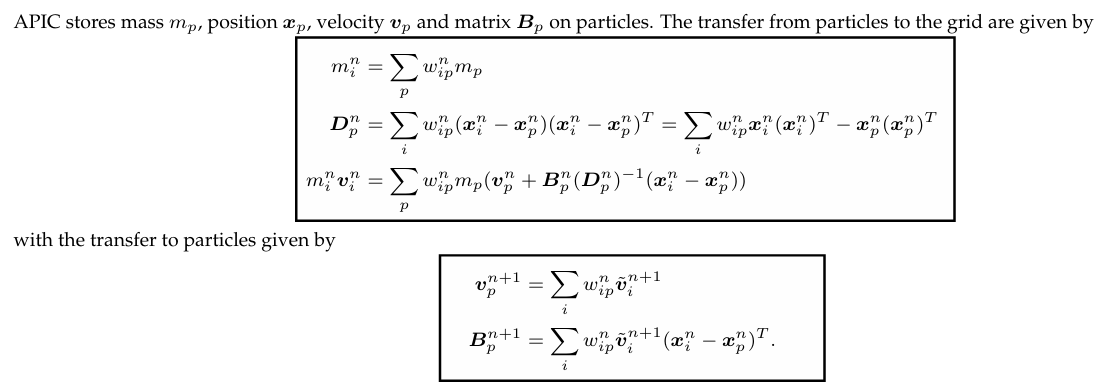

Affine particle in cell (APIC) is the basis of MPM.

It's unbelievable because $\nabla v$ is no longer calculated from $\frac{\partial N}{\partial x}$ but given by this $B D^{-1}$ because the math works.

If given more spare time I would go through the proofs to get more intuition on this.

Techreport: the affine Particle-in-Cellmethod

It's pretty lengthy though.

When using quadratic and cubic interpolation, $D_p=\frac{1}{4}\Delta x^2 I$ and $D_p=\frac{1}{3}\Delta x^2 I$; proofs cannot be found because they think it's **too easy**.

It was, however, not obvious to me at all. It can be proved using special properties of $N(x)$.

Recall that
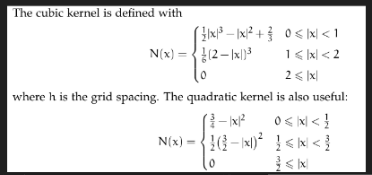

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from sympy import Piecewise,symbols,Rational,Abs

x = symbols("x")
N2 = Piecewise(
    (Rational(1,2)*(Rational(3,2)+x)**2,(-Rational(1,2)>x)&(x>-Rational(3,2))),
    (Rational(3,4)-x*x,(-0.5<x)&(x<0.5)),
    (Rational(1,2)*(Rational(3,2)-x)**2,(Rational(1,2)<x)&(x<Rational(3,2))))
N2

Piecewise(((x + 3/2)**2/2, (x > -3/2) & (x < -1/2)), (3/4 - x**2, (x > -0.5) & (x < 0.5)), ((3/2 - x)**2/2, (x > 1/2) & (x < 3/2)))

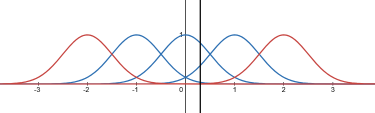

In [2]:
(N2.subs(x,x-1) + N2.subs(x,x+1) + N2).simplify()

Piecewise((1, (x < 0.5) & (x > -1/2)))

In [3]:
(N2.subs(x,x-1)*(x-1) + N2.subs(x,x+1)*(x+1) + N2*x).simplify()

Piecewise((0, (x < 0.5) & (x > -1/2)))

In [4]:
(N2.subs(x,x-1)*(x-1)**2 + N2.subs(x,x+1)*(x+1)**2 + N2*x**2).simplify()

Piecewise((1/4, (x < 0.5) & (x > -1/2)))

In [5]:
N3 = Piecewise(
    (Rational(1,6)*(2-Abs(x))**3,(-1>x)&(x>-2)),
    (Rational(2,3)-x*x+Rational(1,2)*Abs(x)**3,(-1<x)&(x<1)),
    (Rational(1,6)*(2-Abs(x))**3,(2>x)&(x>1)))
N3

Piecewise(((2 - Abs(x))**3/6, (x > -2) & (x < -1)), (-x**2 + Abs(x)**3/2 + 2/3, (x > -1) & (x < 1)), ((2 - Abs(x))**3/6, (x > 1) & (x < 2)))

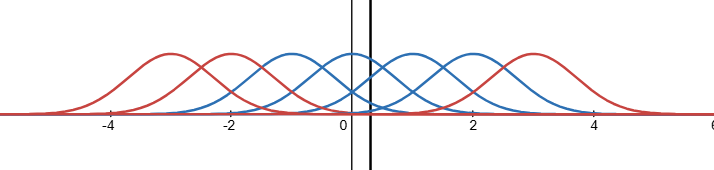

In [18]:
# (N3.subs(x,x-1) + N3.subs(x,x+1) + N3 + N3.subs(x,x-2)).simplify() # never finishes
part1 = Rational(2,3)-x*x+x**3/2
part2 = (2-x)**3/6
(part1+part1.subs(x,1-x)+part2.subs(x,2-x)+part2.subs(x,1+x)).simplify()

1

In [19]:
(part1 * x +
 part1.subs(x,1-x) *(x-1)
 +part2.subs(x,2-x)*(x-2)
 +part2.subs(x,1+x)*(1+x)).simplify()

0

In [20]:
(part1 * x**2 +
 part1.subs(x,1-x) *(x-1)**2
 +part2.subs(x,2-x)*(x-2)**2
 +part2.subs(x,1+x)*(1+x)**2).simplify()

1/3

Imagine 3 nearby grid points with same x, y, but different z. (9 such groups)

let coordinates of the 3 points, $\Delta x$ are $a,b,c$

Define $\Delta a_x = \frac{(a-x_p)}{\Delta x}$

$$
N(\Delta a_x)N(\Delta a_y)N(\Delta a_z)(\Delta x\Delta a_m)(\Delta x\Delta a_n)\\
+N(\Delta b_x)N(\Delta b_y)N(\Delta b_z)(\Delta x\Delta b_m)(\Delta x\Delta b_n)\\
+N(\Delta c_x)N(\Delta c_y)N(\Delta c_z)(\Delta x\Delta c_m)(\Delta x\Delta c_n)
$$
$\Delta a_x=\Delta b_x=\Delta c_x$,

$\Delta a_y=\Delta b_y=\Delta c_y$,

the above sum is

$$
N(\Delta a_x)N(\Delta a_y)(\Delta x)^2(\\
    N(\Delta a_z)\Delta a_m\Delta a_n+\\
    N(\Delta b_z)\Delta b_m\Delta b_n+\\
    N(\Delta c_z)\Delta c_m\Delta c_n
)
$$

#### 3 cases:

1. if $m=n=z$
$$
(\Delta x)^2 N(\Delta a_x)N(\Delta a_y)\left(N(\Delta a_z)\Delta a_z^2+N(\Delta b_z)\Delta b_z^2+N(\Delta c_z)\Delta c_z^2\right)\\
 = \frac{(\Delta x)^2}{4}N(\Delta a_x)N(\Delta a_y)
$$

then see the 3 particles as one, and sum along $y$ (fix $x$), reuse the labels $a,b,c$
$$
\frac{(\Delta x)^2}{4}N(\Delta a_x)(N(\Delta a_y)+N(\Delta b_y)+N(\Delta c_y)) = \frac{(\Delta x)^2}{4}N(\Delta a_x)
$$

sum along $x$
$$
\frac{(\Delta x)^2}{4}(N(\Delta a_x)+N(\Delta b_x)+N(\Delta c_x) = \frac{(\Delta x)^2}{4}
$$

if $m,n\neq z$
$$
(\Delta x)^2\Delta a_m\Delta a_n N(\Delta a_x)N(\Delta a_y)(N(\Delta a_z)+N(\Delta c_z)+N(\Delta c_z))\\ = (\Delta x)^2\Delta a_m\Delta a_n N(\Delta a_x)N(\Delta a_y)
$$
2. $m=n$

WLOG, $m=n=x$, sum along $y$ as before,
$$
(\Delta x)^2\Delta a_x^2 N(\Delta a_x)\big(N(\Delta a_y) + N(\Delta b_y) + N(\Delta c_y)\big)\\ = (\Delta x)^2\Delta a_x^2 N(\Delta a_x)
$$

then sum along $x$,
$$
(\Delta x)^2 \big(N(\Delta a_x)(\Delta x)^2+N(\Delta b_x)(\Delta x)^2+N(\Delta b_x)(\Delta x)^2\big) = \frac{(\Delta x)^2}{4}
$$

3. $m\neq n$

if $m,n\neq z$
WLOG, $m=x,n=y$

sum along $y$,
$$
(\Delta x)^2\Delta a_x N(\Delta a_x)\big(N(\Delta a_y)\Delta a_y + N(\Delta b_y)\Delta a_y + N(\Delta c_y)\Delta a_y\big)\\ = 0
$$

you can manually evaluate the case when one of $m,n$ is $z$.

But due to symmetry, it's the same as above (just don't sum along $z$ in the first step)

$\displaystyle (D_p)_{mn} = \sum_i w_{ip}(x_i-x_p)_m(x_i-x_p)_n = \frac{(\Delta x)^2}{4}\delta_{mn}$, QED

(for cubic case, sum 5 times on each axis)

Am I over-complicating things?